In [1]:
%load_ext autoreload
%autoreload 2

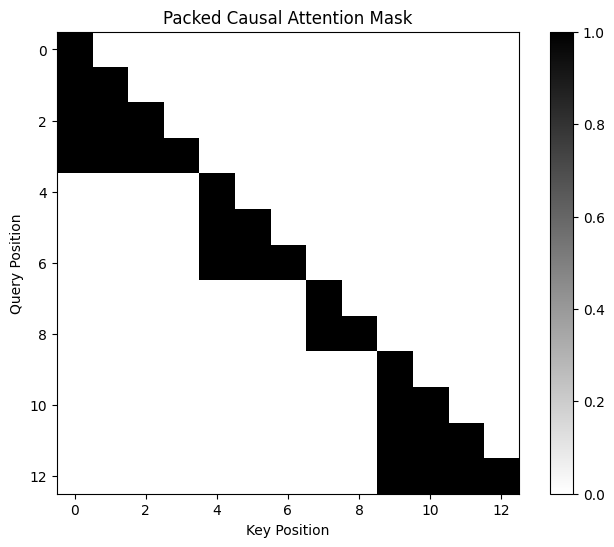

In [31]:
import matplotlib.pyplot as plt
import torch
from typing import Optional


def create_packed_causal_mask(tokens: torch.Tensor, *, bos_id: int) -> torch.Tensor:
    """
    Creates a causal attention mask for packed sequences, where each sequence starts with a BOS token.

    Args:
        tokens: Input tensor of shape [b x s] containing token ids
        bos_token_id: Token ID used to mark the start of sequences.

    Returns:
        Boolean tensor of shape [b x s x s] where True means position i can attend to position j
    """
    _, seq_len = tokens.shape

    # Compute causal mask
    causal_mask = torch.tril(
        torch.ones(seq_len, seq_len, dtype=torch.bool, device=tokens.device)
    )

    # Compute sequence IDs by cumulative sum of BOS tokens
    seq_ids = torch.cumsum(tokens == bos_id, dim=-1)

    # Determine if positions are in the same sequence
    same_sequence = seq_ids.unsqueeze(-1) == seq_ids.unsqueeze(-2)

    # Apply sequence boundary masking
    causal_mask = causal_mask & same_sequence

    return causal_mask


# Test packed causal mask
tokens = torch.tensor([[1, 2, 3, 1, 2, 3], [1, 2, 1, 2, 1, 2]])
tokens = torch.tensor(
    [[1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]]
)
causal_mask = create_packed_causal_mask(tokens, bos_id=1)

plt.figure(figsize=(8, 6))
plt.imshow(causal_mask[0], cmap="binary")
plt.colorbar()
plt.title("Packed Causal Attention Mask")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.show()

In [28]:
def get_input_pos(tokens: torch.Tensor, bos_id: int) -> torch.Tensor:
    """Returns position IDs relative to sequence starts in packed input."""
    positions = torch.arange(tokens.size(1), device=tokens.device).expand_as(tokens)
    seq_start_pos, _ = torch.cummax(positions * (tokens == bos_id).int(), dim=1)
    return positions - seq_start_pos

get_input_pos(tokens, bos_id=1)

tensor([[0, 1, 2, 3, 0, 1, 2, 0, 1, 0, 1, 2, 3],
        [0, 1, 2, 3, 0, 1, 2, 0, 1, 0, 1, 2, 3]])

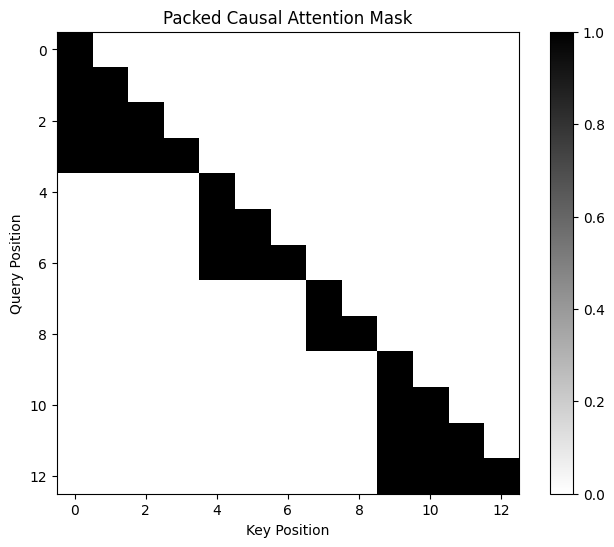

In [15]:
import torch
import matplotlib.pyplot as plt

tokens = torch.tensor([1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0])

# Compute causal mask
causal_mask = torch.tril(torch.ones(len(tokens), len(tokens), dtype=torch.bool))

# Compute sequence IDs by cumulative sum of tokens == 1
seq_ids = torch.cumsum(tokens == 1, dim=0)

# Determine if positions are in the same sequence
same_sequence = seq_ids.unsqueeze(0) == seq_ids.unsqueeze(1)

# Apply sequence boundary masking
causal_mask &= same_sequence

plt.figure(figsize=(8, 6))
plt.imshow(causal_mask, cmap="binary")
plt.colorbar()
plt.title("Packed Causal Attention Mask")
plt.xlabel("Key Position") 
plt.ylabel("Query Position")
plt.show()

In [16]:
causal_mask.to(torch.int)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]], dtype=torch.int32)

In [ ]:
from lib.recipes.full_finetune import ComponentConfig, FullFinetuneConfig, recipe_main
import subprocess
from torch.optim.adamw import AdamW
from torchtune.datasets import alpaca_dataset
from torchtune.models.llama3 import llama3_tokenizer
from torchtune.models.llama3_1 import llama3_1_8b
from torchtune.modules.loss import CEWithChunkedOutputLoss
from torchtune.training import FullModelHFCheckpointer
from torchtune.training.metric_logging import DiskLogger
from typing import Any

PLACEHOLDER: Any = None

checkpoint_dir = subprocess.run(
    "HF_HUB_ENABLE_HF_TRANSFER=1 huggingface-cli download NousResearch/Hermes-2-Theta-Llama-3-8B",
    shell=True,
    capture_output=True,
    text=True,
).stdout.strip()

recipe_main(
    FullFinetuneConfig(
        # Tokenizer
        tokenizer=ComponentConfig(
            llama3_tokenizer,  # type: ignore
            path="/home/ubuntu/atreides/.venv/lib/python3.12/site-packages/llama_models/llama3/api/tokenizer.model",
            max_seq_len=None,
        ),
        # Dataset
        dataset=ComponentConfig(alpaca_dataset, tokenizer=PLACEHOLDER, packed=False),
        seed=None,
        shuffle=True,
        # Model
        model=ComponentConfig(llama3_1_8b),
        # Checkpointer
        checkpointer=ComponentConfig(
            FullModelHFCheckpointer,
            checkpoint_dir=checkpoint_dir,
            checkpoint_files=[
                "model-00001-of-00004.safetensors",
                "model-00002-of-00004.safetensors",
                "model-00003-of-00004.safetensors",
                "model-00004-of-00004.safetensors",
            ],
            recipe_checkpoint=None,
            output_dir="/tmp/Hermes-2-Theta-Llama-3-8B/",
            model_type="LLAMA3",
        ),
        resume_from_checkpoint=False,
        # Fine-tuning arguments
        batch_size=12,
        epochs=3,
        optimizer=ComponentConfig(AdamW, params=PLACEHOLDER, lr=2e-5, fused=True),
        loss=ComponentConfig(CEWithChunkedOutputLoss),
        max_steps_per_epoch=None,
        compile=True,
        optimizer_in_bwd=False,
        gradient_accumulation_steps=1,
        # Training env
        device="cuda",
        # Memory management
        enable_activation_checkpointing=True,
        enable_activation_offloading=False,
        custom_sharded_layers=["tok_embeddings", "output"],
        # Reduced precision
        dtype="bf16",
        # Logging
        metric_logger=ComponentConfig(
            DiskLogger, log_dir="/home/ubuntu/atreides/experiments/logs"
        ),
        output_dir="/home/ubuntu/atreides/experiments/logs",
        log_every_n_steps=16,
        log_peak_memory_stats=True,
    )
)

In [2]:
from lib.tokenizer import Tokenizer

tokenizer = Tokenizer(model="NousResearch/Hermes-2-Theta-Llama-3-8B")

/home/ubuntu/atreides/.venv/lib/python3.12/site-packages/vllm/connections.py:8: RuntimeWarning: Failed to read commit hash:
No module named 'vllm._version'
  from vllm.version import __version__ as VLLM_VERSION


INFO 10-31 00:23:16 llm_engine.py:237] Initializing an LLM engine (vdev) with config: model='NousResearch/Hermes-2-Theta-Llama-3-8B', speculative_config=None, tokenizer='NousResearch/Hermes-2-Theta-Llama-3-8B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=NousResearch/Hermes-2-Theta-Llama-3-8B, use_v2_block_manager=True, num_scheduler_steps=1, chunked_

In [3]:
from torchtune.models.llama3_1 import llama3_1_8b

model = llama3_1_8b()

In [4]:
import glob
import subprocess

model_dir = subprocess.run(
    "HF_HUB_ENABLE_HF_TRANSFER=1 huggingface-cli download NousResearch/Hermes-2-Theta-Llama-3-8B",
    shell=True,
    capture_output=True,
    text=True,
).stdout.strip()

print(model_dir)

/home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/snapshots/57a73110702e7b05ba3f39fef36297454c680725


In [5]:
import os
from torchtune.training.checkpointing import FullModelHFCheckpointer

output_dir = "./models/test"
os.makedirs(output_dir, exist_ok=True)

checkpointer = FullModelHFCheckpointer(
    checkpoint_dir=model_dir,
    checkpoint_files=glob.glob(f"{model_dir}/*.safetensors")
    + glob.glob(f"{model_dir}/*.pt"),
    output_dir=output_dir,
    model_type="LLAMA3",  # type: ignore
)
state_dict = checkpointer.load_checkpoint()
state_dict.keys()

dict_keys(['model'])

In [6]:
model.load_state_dict(state_dict["model"])

<All keys matched successfully>

In [7]:
# Check if model is compiled
is_compiled = hasattr(model, '_orig_mod')
print(is_compiled)

False


In [8]:
from lib.rl import Completion

root = Completion.model_validate_json(open("./data/completions.json").read())

In [10]:
max_length = 0
for leaf in root.leaves():
    length = len(tokenizer.encode(leaf.all_message_params()))
    if length > max_length:
        max_length = length
        clear_output()
        print(max_length)

In [19]:
len(tokenizer.encode([{"role": "user", "content": "Hello, how are you?"},]))

12

In [10]:
import os
import shutil

epoch = 1

# Save the model
checkpointer.save_checkpoint(dict(model=model.state_dict()), epoch)

# Create target directory if it doesn't exist
os.makedirs(f"{output_dir}/{epoch:04d}", exist_ok=True)

# Copy all non-safetensors files from model_dir to target
for file in os.listdir(model_dir):
    if not file.endswith(".safetensors") and not file.endswith(".pt"):
        src = os.path.join(model_dir, file)
        dst = os.path.join(f"{output_dir}/{epoch:04d}", file)
        shutil.copy2(src, dst)

# Move all .pt files from ./models/test to ./models/test/0000
for file in os.listdir(output_dir):
    if file.endswith(".pt"):
        src = os.path.join(output_dir, file)
        dst = os.path.join(f"{output_dir}/{epoch:04d}", file)
        shutil.move(src, dst)

INFO:torchtune.utils._logging:Model checkpoint of size 9.95 GB saved to models/test/hf_model_0001_1.pt
INFO:torchtune.utils._logging:Model checkpoint of size 10.00 GB saved to models/test/hf_model_0002_1.pt
INFO:torchtune.utils._logging:Model checkpoint of size 9.83 GB saved to models/test/hf_model_0003_1.pt
INFO:torchtune.utils._logging:Model checkpoint of size 2.34 GB saved to models/test/hf_model_0004_1.pt
INFO:torchtune.utils._logging:Saving final epoch checkpoint.
INFO:torchtune.utils._logging:The full model checkpoint, including all weights and configurations, has been saved successfully.You can now use this checkpoint for further training or inference.


In [7]:
def get_tokens(messages: list[dict]) -> list[int]:
    generate = llm.generate

    def get_tokens(prompts: list[dict], *args: object, **kwargs: object) -> list[int]:
        return llm.get_tokenizer().encode(prompts[0]["prompt"])

    llm.generate = get_tokens  # type: ignore
    tokens = llm.chat(messages)  # type: ignore
    llm.generate = generate  # type: ignore
    return tokens  # type: ignore


get_tokens([dict(role="user", content=prompt)])

[128000,
 128000,
 128002,
 882,
 198,
 1966,
 264,
 8369,
 10683,
 1938,
 19367,
 11,
 480,
 285,
 6853,
 323,
 58280,
 7731,
 1523,
 311,
 1514,
 264,
 16736,
 23347,
 1847,
 382,
 7009,
 35105,
 220,
 18,
 30881,
 315,
 7563,
 11,
 1855,
 369,
 264,
 8821,
 955,
 315,
 2038,
 24306,
 315,
 279,
 2768,
 1473,
 78524,
 1002,
 512,
 12,
 9083,
 81818,
 198,
 12,
 4491,
 13,
 7997,
 198,
 12,
 18083,
 13,
 5929,
 271,
 29314,
 512,
 12,
 73997,
 30133,
 198,
 12,
 62302,
 198,
 12,
 30982,
 28905,
 271,
 14330,
 512,
 12,
 11166,
 198,
 12,
 50767,
 198,
 12,
 39190,
 10637,
 271,
 6153,
 27716,
 320,
 438,
 89447,
 8,
 19301,
 832,
 3786,
 505,
 1855,
 1912,
 323,
 25012,
 1124,
 304,
 279,
 6278,
 315,
 279,
 2007,
 17011,
 785,
 11,
 814,
 75371,
 279,
 9861,
 7563,
 323,
 27023,
 704,
 279,
 2768,
 311,
 1855,
 2851,
 1473,
 12,
 19367,
 25,
 220,
 17,
 7563,
 198,
 12,
 480,
 285,
 6853,
 25,
 220,
 17,
 7563,
 4417,
 43,
 26645,
 518,
 364,
 36412,
 81818,
 1329,
 12,
 58280,
 25,

In [9]:
import gc
import torch
from vllm.distributed.parallel_state import destroy_model_parallel

destroy_model_parallel()
del llm.llm_engine.model_executor.driver_worker  # type: ignore
gc.collect()
torch.cuda.empty_cache()

In [10]:
model.to("cuda")

TransformerDecoder(
  (tok_embeddings): Embedding(128256, 4096)
  (layers): ModuleList(
    (0-31): 32 x TransformerSelfAttentionLayer(
      (attn): MultiHeadAttention(
        (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (output_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (pos_embeddings): Llama3ScaledRoPE()
      )
      (mlp): FeedForward(
        (w1): Linear(in_features=4096, out_features=14336, bias=False)
        (w2): Linear(in_features=14336, out_features=4096, bias=False)
        (w3): Linear(in_features=4096, out_features=14336, bias=False)
        (activation): SiLU()
      )
      (sa_norm): RMSNorm()
      (mlp_norm): RMSNorm()
      (sa_scale): Identity()
      (mlp_scale): Identity()
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=4096, out_features=128256

In [11]:
next(model.parameters()).device

device(type='cuda', index=0)

In [16]:
import torch
from torchtune.generation import generate

result = generate(
    model,
    torch.tensor([get_tokens([dict(role="user", content=prompt)])], device="cuda"),
    max_generated_tokens=10,
)

In [17]:
print(llm.get_tokenizer().decode(result[0].squeeze().tolist()))

<|begin_of_text|><|begin_of_text|><|im_start|>user
On a warm spring day Summer, Giselle and Connor sat down to play a casual mystery game.

They assembled 3 decks of cards, each for a separate type of information composed of the following:

Suspect:
- Miss Scarlet
- Mr. Green
- Mrs. White

Weapon:
- Candlestick
- Knife
- Lead Pipe

Room:
- Hall
- Lounge
- Dining Room

After randomly (and blindly) choosing one card from each group and placing them in the middle of the table facedown, they shuffled the remaining cards and dealt out the following to each player:

- Summer: 2 cards
- Giselle: 2 cards ('Lounge', 'Miss Scarlet')
- Connor: 2 cards

The game proceeded as follows:

1. On their turn, a player asked about a set of exactly 3 cards, one from each of the game's categories. (Note: Players could ask about any cards, including those in their own hand.)
2. The player directed this question to the other players in clockwise order, starting with the player to their left.
3. If a player ha

In [22]:
torch.tensor([get_tokens([dict(role="user", content=prompt)])] * 2, device="cuda").shape

torch.Size([2, 585])

In [23]:
model.forward(torch.tensor([get_tokens([dict(role="user", content=prompt)])] * 2, device="cuda"))

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 39.38 GiB of which 37.38 MiB is free. Including non-PyTorch memory, this process has 39.33 GiB memory in use. Of the allocated memory 38.62 GiB is allocated by PyTorch, and 166.44 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)